In [27]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.optim import Adam
from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

In [3]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine

from pyro.infer.mcmc.util import predictive

import matplotlib.pyplot as plt

pyro.set_rng_seed(42)

In [5]:
# for CI testing
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cpu')

In [8]:
sigma_noise = 0.1
N = 200
np.random.seed(40)

In [29]:
X1 = Uniform(torch.tensor([-1.0]), torch.tensor([-0.63])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X2 = Uniform(torch.tensor([0.45]), torch.tensor([1.1])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X = torch.cat((X1, X2), 0)
X.detach()

tensor([-0.7174, -0.8744, -0.8743, -0.9289, -0.7723, -0.6980, -0.9137, -0.9275,
        -0.9103, -0.9009, -0.6999, -0.6645, -0.8840, -0.8275, -0.7616, -0.8686,
        -0.6417, -0.9012, -0.8674, -0.9541, -0.9457, -0.8283, -0.9949, -0.9927,
        -0.8010, -0.9558, -0.7090, -0.9637, -0.6335, -0.8107, -0.7354, -0.8291,
        -0.7599, -0.8148, -0.9769, -0.6329, -0.8309, -0.7286, -0.8977, -0.7856,
        -0.7637, -0.6388, -0.9864, -0.6348, -0.8037, -0.8688, -0.7917, -0.6440,
        -0.7921, -0.8701, -0.8611, -0.9584, -0.9909, -0.6338, -0.6310, -0.8343,
        -0.9719, -0.6407, -0.8707, -0.8736, -0.6860, -0.8474, -0.8326, -0.9897,
        -0.9394, -0.6981, -0.6657, -0.7877, -0.8391, -0.6651, -0.8389, -0.9519,
        -0.8732, -0.6835, -0.6924, -0.6973, -0.8641, -0.7465, -0.7071, -0.7450,
        -0.6334, -0.8107, -0.7904, -0.9166, -0.8502, -0.7275, -0.6435, -0.6924,
        -0.8003, -0.8888, -0.9264, -0.7604, -0.8707, -0.7267, -0.8796, -0.8160,
        -0.6664, -0.7303, -0.6657, -0.68

In [32]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma_noise, size=N)).detach().float()
y = torch.cos(4.0*(X+0.2)) + e
y.detach()

tensor([-0.4783, -1.1208, -0.9920, -0.9171, -0.6968, -0.4433, -1.1776, -0.9525,
        -0.9587, -1.1165, -0.4928, -0.2391, -0.8222, -0.7209, -0.5918, -0.7254,
        -0.0295, -0.9392, -1.0102, -0.8980, -0.8478, -0.8416, -1.2139, -1.0273,
        -0.7089, -0.9417, -0.4177, -0.8768, -0.2990, -0.8474, -0.3305, -0.8278,
        -0.7324, -0.7236, -0.9251, -0.1507, -0.9844, -0.4820, -0.7486, -0.8035,
        -0.4490, -0.1894, -0.9130,  0.1335, -0.9971, -0.7945, -0.7622, -0.1468,
        -0.6750, -0.9863, -0.8007, -1.0975, -0.9451, -0.0834, -0.0582, -0.8652,
        -1.0169, -0.1345, -0.8152, -0.9248, -0.2476, -0.8152, -0.8957, -0.9061,
        -1.0325, -0.3761, -0.3712, -0.5548, -1.0027, -0.4205, -0.8930, -1.0370,
        -0.8321, -0.3377, -0.0907, -0.3994, -0.7523, -0.5494, -0.4067, -0.5850,
        -0.2324, -0.7384, -0.8826, -0.6575, -0.8832, -0.6689, -0.2942, -0.3570,
        -0.7574, -0.9785, -0.9138, -0.6058, -0.8404, -0.5518, -1.1152, -0.9356,
        -0.3373, -0.5891, -0.1536, -0.41

In [33]:
x_data, y_data = X.unsqueeze(1), y

In [34]:
type(x_data)

torch.Tensor

In [35]:
x_data.shape

torch.Size([200, 1])

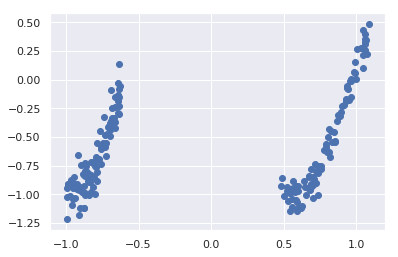

In [36]:
plt.scatter(X,y)

In [37]:
H = 50

In [38]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(p, H)
        self.linear2 = nn.Linear(H,1)
        self.to(device)

    def forward(self, x):
        out = torch.tanh(self.linear1(x))
        out = self.linear2(out)
        return out

p = 1
softplus = nn.Softplus()
regression_model = RegressionModel(p)

In [39]:
def model(x_data, y_data):
    options = dict(dtype=x_data.dtype, device=x_data.device)
    
    weight_loc = torch.zeros(H, p, **options)
    weight_scale = 5*torch.ones(H, p, **options)
    bias_loc = torch.zeros(H, **options)
    bias_scale = 5*torch.ones(H, **options)
    
    linear1_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear1_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    weight_loc = torch.zeros(1, H, **options)
    weight_scale = 5*torch.ones(1, H, **options)
    bias_loc = torch.zeros(1, **options)
    bias_scale = 5*torch.ones(1, **options)
    
    linear2_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear2_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear1.weight': linear1_w_prior, 'linear1.bias': linear1_b_prior,
              'linear2.weight': linear2_w_prior, 'linear2.bias': linear2_b_prior,}
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    
    lifted_reg_model = lifted_module()
    
    with pyro.plate("map", device=x_data.device):
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs", Normal(prediction_mean, sigma_noise), obs=y_data)
    return prediction_mean

In [40]:
nuts_kernel = NUTS(model)
mcmc_run = MCMC(nuts_kernel, num_samples=10, warmup_steps=0, num_chains=1)

In [19]:
Net = RegressionModel(1)

In [20]:
mcmc_run.run(x_data, y_data)
mcmc_run.summary()

sample: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, step size=1.95e-03, acc. prob=0.715]




                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 module$$$linear1.weight[0,0]     -1.01      1.13     -0.60     -3.14      0.17      2.90      1.73
 module$$$linear1.weight[1,0]     -1.32      0.56     -1.34     -2.29     -0.14      5.67      0.95
 module$$$linear1.weight[2,0]      2.60      1.44      1.62      1.25      5.32      2.67      2.07
 module$$$linear1.weight[3,0]     -1.17      0.40     -1.29     -1.63     -0.70      8.25      0.90
 module$$$linear1.weight[4,0]      0.56      0.66      0.34     -0.30      1.72      3.86      2.10
 module$$$linear1.weight[5,0]     -0.39      0.99     -0.58     -1.52      0.91      4.04      1.27
 module$$$linear1.weight[6,0]     -0.30      0.87     -0.17     -1.81      0.90      4.21      1.49
 module$$$linear1.weight[7,0]      0.51      0.65      0.33     -0.41      1.49      6.93      0.90
 module$$$linear1.weight[8,0]      0.36      0.76      0.46     -0.59      1.95      6.75      1.2

In [22]:
samples = mcmc_run.get_samples()
traces = predictive(model, samples, x_data, None, return_trace=True)

/home/mathieu/anaconda3/lib/python3.7/site-packages/pyro/infer/mcmc/util.py:538: ExperimentalWarning: This function or its interface might change in the future.
  ExperimentalWarning)


In [23]:
for i in range(0,150):
    traces[i].compute_log_prob()
    print(traces[i].nodes['obs']['log_prob_sum'])

tensor(164.3875)
tensor(178.4644)
tensor(188.1789)
tensor(179.8758)
tensor(166.9544)
tensor(183.5657)
tensor(170.4993)
tensor(192.3559)
tensor(190.1693)
tensor(183.4692)


IndexError: list index out of range

In [24]:
traces[1].nodes['_RETURN']['value']

tensor([-0.3483, -0.9563, -0.7931, -0.3755, -1.2892, -0.2989, -0.8009, -0.3521,
        -0.5787, -0.7465, -0.4922, -0.6357, -0.4383, -0.9221, -0.7143, -0.7254,
        -0.5750, -0.6699, -0.1460, -0.4713, -0.9106, -1.0645, -0.7759, -0.9497,
        -0.8763, -0.6366, -0.3010, -0.3316, -1.3131, -0.2873, -0.4910, -0.1068,
        -0.2643, -1.2690, -1.2954, -0.9835, -0.1439, -0.7753, -0.4003, -0.9718,
        -0.0899, -0.9442, -0.2137, -0.6597, -1.0131, -0.3490, -1.0158, -0.4819,
        -0.8554, -0.7382, -1.3024, -0.9798, -0.3322, -0.8254, -0.0823, -0.1852,
        -0.6975, -1.1068, -0.2936, -0.4719, -1.0927, -0.2703, -0.2946, -0.1392,
        -1.0356, -0.7740, -0.6798, -0.5743, -1.1677, -1.1349, -0.3314, -0.8197,
        -0.3641, -0.6308, -0.4608, -0.5279, -0.4393, -0.3598, -1.2790, -0.3553,
        -1.1305, -1.1648, -0.6284, -0.7778, -0.3061, -1.0479, -1.2543, -0.2261,
        -0.7633, -0.3206, -0.4650, -1.1617, -0.5398, -0.5153, -1.1082, -0.9783,
        -0.4531, -0.5534, -0.9457, -0.86

In [25]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)
traces_test = predictive(model, samples, x_test, None, return_trace=True)

/home/mathieu/anaconda3/lib/python3.7/site-packages/pyro/infer/mcmc/util.py:538: ExperimentalWarning: This function or its interface might change in the future.
  ExperimentalWarning)


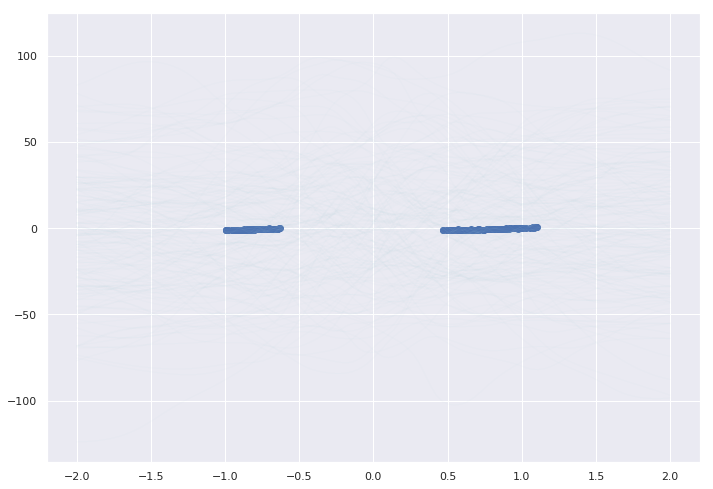

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(X,y)
for _ in range(150):
    guide_trace = poutine.trace(model).get_trace(x_test, None)
    lifted_reg_model = poutine.replay(model, guide_trace)
    y_test = lifted_reg_model(x_test, None)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

tuple